## Libraries

In [ ]:
# [IMPORTS] Core & Audio Processing
import os
import glob
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import copy

# [IMPORTS] Audio & Visualization
import librosa
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd

# [IMPORTS] PyTorch & ML
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio.transforms as T
import torch.nn.init as init
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR

# [IMPORTS] Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr

# [IMPORTS] Other
from google.colab import drive
import tarfile
import warnings
warnings.filterwarnings('ignore')


## Dataset loading from google drive



In [ ]:
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
# Percorsi di origine e destinazione
drive_root = '/content/drive/MyDrive/mel_sequences_final'
base_output = '/content/mel_dataset'

# Cartelle di output
split_dirs = {
    'train': os.path.join(base_output, 'train'),
    'valid': os.path.join(base_output, 'valid'),
    'test': os.path.join(base_output, 'test')
}

# Crea cartelle di output
for split, out_dir in split_dirs.items():
    os.makedirs(out_dir, exist_ok=True)

# Mappa dei file da estrarre in ciascuna cartella
tar_map = {
    'mel_sequences_train.tar.gz': split_dirs['train'],
    'mel_sequences_valid.tar.gz': split_dirs['valid'],
    'mel_sequences_test.tar.gz':  split_dirs['test'],
}

# Estrazione per split
for tar_name, output_dir in tar_map.items():
    tar_path = os.path.join(drive_root, tar_name)
    print(f"📦 Estraendo {tar_name} in {output_dir}...")
    with tarfile.open(tar_path, 'r:gz') as tar:
        tar.extractall(path=output_dir)

print("Estrazione completata. Cartelle create:")
for split, path in split_dirs.items():
    print(f"  📁 {split}: {path}")

📦 Estraendo mel_sequences_train.tar.gz in /content/mel_dataset/train...
📦 Estraendo mel_sequences_valid.tar.gz in /content/mel_dataset/valid...
📦 Estraendo mel_sequences_test.tar.gz in /content/mel_dataset/test...
Estrazione completata. Cartelle create:
  📁 train: /content/mel_dataset/train
  📁 valid: /content/mel_dataset/valid
  📁 test: /content/mel_dataset/test


## Dataset creation

In [ ]:
class MelSequenceDataset(Dataset):

    def __init__(self, mel_dir, transform=None):
        self.files = sorted(glob.glob(os.path.join(mel_dir, '*.npz')))
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        data = np.load(self.files[idx])
        mel = data['mel']
        label = data['label']
        if self.transform:
            mel = self.transform(mel)
        return torch.tensor(mel, dtype=torch.float32), torch.tensor(label, dtype=torch.float32)


In [ ]:
train_dataset = MelSequenceDataset('/content/mel_dataset/train')
valid_dataset = MelSequenceDataset('/content/mel_dataset/valid')
test_dataset  = MelSequenceDataset('/content/mel_dataset/test')

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
devel_loader = DataLoader(valid_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

### Visualizzazione del Mel Spectrogramma di un segmento

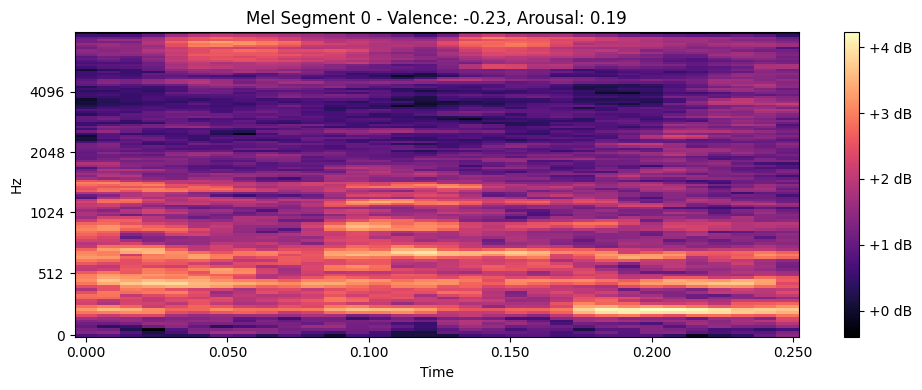

In [ ]:
sample_input, sample_target = train_dataset[1]
mel = sample_input[1, 0].numpy()

plt.figure(figsize=(10, 4))
librosa.display.specshow(mel, sr=16000, hop_length=256, x_axis='time', y_axis='mel',cmap='magma')
plt.colorbar(format='%+2.0f dB')
plt.title(f"Mel Segment 0 - Valence: {sample_target[1, 0]:.2f}, Arousal: {sample_target[1, 1]:.2f}")
plt.tight_layout()
plt.show()

### Visualizzazione del Mel Spectrogramma di una sequenza

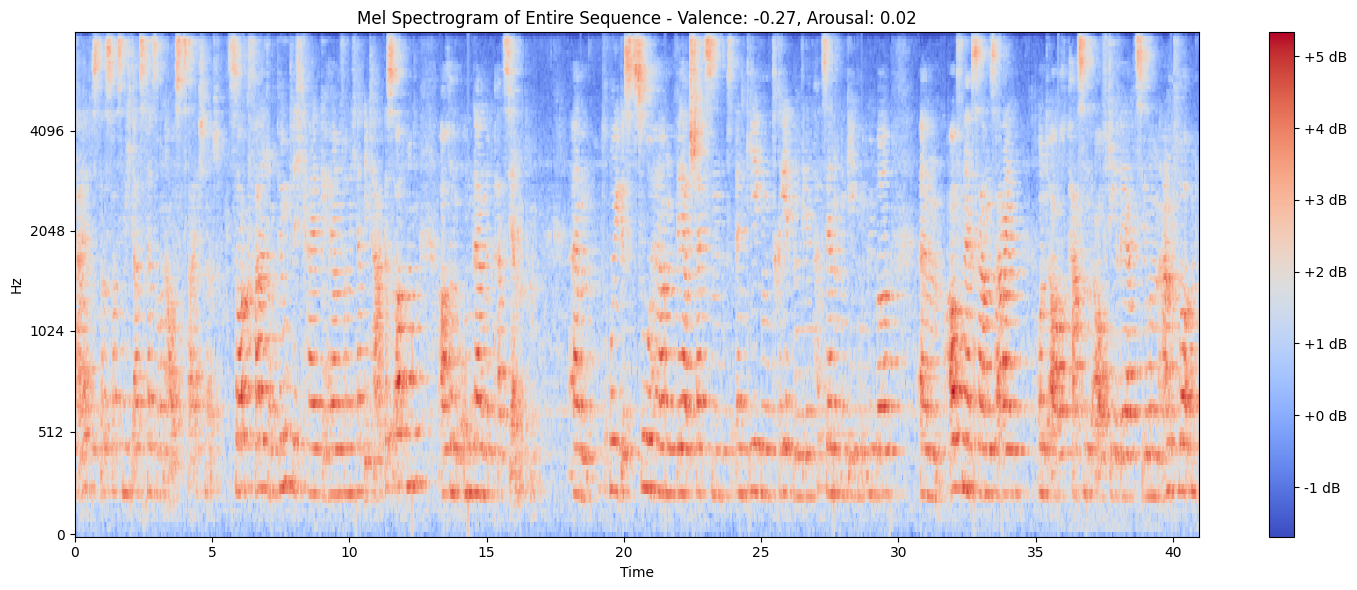

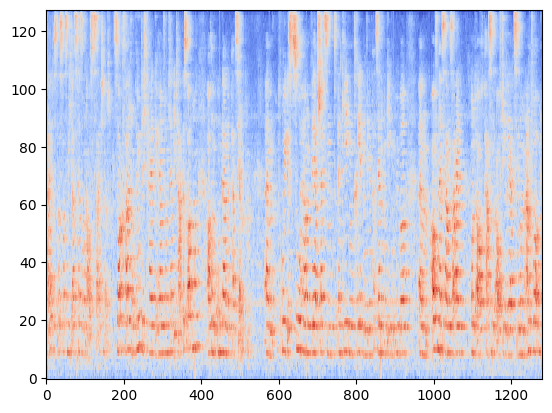

In [ ]:
mel_sequence = sample_input.numpy().squeeze(1)

mel_sequence_merged = np.concatenate(mel_sequence, axis=-1)

plt.figure(figsize=(15, 6))
librosa.display.specshow(mel_sequence_merged, sr=16000, hop_length=256, x_axis='time', y_axis='mel',cmap='magma')
plt.colorbar(format='%+2.0f dB')
plt.title(f"Mel Spectrogram of Entire Sequence - Valence: {sample_target[-1, 0]:.2f}, Arousal: {sample_target[-1, 1]:.2f}")
plt.tight_layout()
plt.show()

## Funzioni per il ripristino dell'adddestramento su un altro account

In [ ]:
def save_checkpoint(state, checkpoint_dir, filename='last.ckpt'):

    os.makedirs(checkpoint_dir, exist_ok=True)
    path = os.path.join(checkpoint_dir, filename)
    torch.save(state, path)
    print(f"✅ Checkpoint salvato in {path}")


def load_checkpoint(model, optimizer, scheduler, checkpoint_dir, filename='last.ckpt', device='cpu'):

    path = os.path.join(checkpoint_dir, filename)
    if not os.path.exists(path):
        return 0, {}
    print(f"🔄 Carico checkpoint da {path}")
    ckpt = torch.load(path, map_location=device, weights_only=False)
    model.load_state_dict(ckpt['model_state'])
    optimizer.load_state_dict(ckpt['optim_state'])
    if scheduler and 'sched_state' in ckpt:
        scheduler.load_state_dict(ckpt['sched_state'])
    history = ckpt.get('history', {})
    start_epoch = ckpt.get('epoch', 0) + 1
    if 'torch_rng' in ckpt:
        torch.set_rng_state(ckpt['torch_rng'].type(torch.ByteTensor))
    if 'np_rng' in ckpt:
        np.random.set_state(ckpt['np_rng'])
    return start_epoch, history


def plot_history(history, start_epoch=0):

    epochs = list(range(len(history.get('train_loss', []))))
    if not epochs:
        return

    plt.figure()
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'],   label='Valid Loss')
    plt.axvline(start_epoch-1, color='gray', linestyle='--', alpha=0.5, label='Ripresa' if start_epoch>0 else '')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training History')
    plt.show()

## Model

In [ ]:
class CNNRNNAttention(nn.Module):
    def __init__(self, n_mels=128, hidden_size=128, n_lstm_layers=2):
        super(CNNRNNAttention, self).__init__()

        self.conv_block = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, padding=1),
            nn.BatchNorm2d(8),
            nn.ELU(),
            nn.MaxPool2d(2),

            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ELU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ELU(),
            nn.MaxPool2d(4),

        )

        self.rnn = nn.LSTM(input_size=512, hidden_size=hidden_size,
                           num_layers=n_lstm_layers, batch_first=True, bidirectional=True)

        self.attn = nn.Linear(2*hidden_size, 1)

        self.fc_valence = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4*hidden_size, 1),
        )

        self.initialize_weights()

    def forward(self, x):
        batch_size, seq_len, C, H, W = x.shape

        x = x.view(batch_size * seq_len, C, H, W)
        x = self.conv_block(x)

        x = x.view(batch_size, seq_len, -1)
        rnn_out, _ = self.rnn(x)

        scores = torch.tanh(self.attn(rnn_out))
        alpha  = torch.softmax(scores, dim=1)
        context = torch.sum(rnn_out * alpha, dim=1)

        last_out=rnn_out[:, -1, :]
        out=torch.cat([context,last_out], dim=1)

        valence_output = self.fc_valence(out)

        return valence_output


    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

            elif isinstance(m, nn.Linear):
                init.kaiming_normal_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

            elif isinstance(m, nn.LSTM):
                for name, param in m.named_parameters():
                    if 'weight_ih' in name:
                        init.xavier_uniform_(param.data)
                    elif 'weight_hh' in name:
                        init.orthogonal_(param.data)
                    elif 'bias' in name:
                        param.data.fill_(0)
                        n = param.size(0)
                        param.data[n//4:n//2].fill_(1)

            elif isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

## CCC Calculation

In [ ]:
def concordance_correlation_coefficient(y_true, y_pred, eps=1e-8):

    mean_true = torch.mean(y_true)
    mean_pred = torch.mean(y_pred)

    var_true = torch.var(y_true, unbiased=False)
    var_pred = torch.var(y_pred, unbiased=False)

    cov = torch.mean((y_true - mean_true) * (y_pred - mean_pred))

    ccc = (2 * cov) / (var_true + var_pred + (mean_true - mean_pred) ** 2 + eps)
    return ccc


In [ ]:
def ccc(y_true, y_pred, eps=1e-8):
    mean_true = np.mean(y_true)
    mean_pred = np.mean(y_pred)
    var_true = np.var(y_true)
    var_pred = np.var(y_pred)
    covariance = np.mean((y_true - mean_true) * (y_pred - mean_pred))
    ccc = (2 * covariance) / (var_true + var_pred + (mean_true - mean_pred) ** 2 + eps)
    return ccc

In [ ]:
def ccc_loss(y_pred, y_true):
    ccc = concordance_correlation_coefficient(y_true, y_pred)
    return (1 - ccc)


## Model training

In [ ]:
def plot_scatter(targets, predictions, label='Valence'):

    targets = np.array(targets)
    predictions = np.array(predictions)

    plt.figure(figsize=(6, 6))
    plt.scatter(targets, predictions, alpha=0.5, edgecolor='k')
    plt.plot([-1, 1], [-1, 1], 'r--', lw=2)
    plt.xlabel(f'Target {label}')
    plt.ylabel(f'Predicted {label}')
    plt.title(f'Scatter Plot - {label}')
    plt.grid(True)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

In [ ]:
def train_model(model,
                train_loader,
                val_loader,
                num_epochs=50,
                patience=10,
                lr=1e-3,
                checkpoint_dir=None,
                resume=False,
                start_from_epoch=None,
                device='cuda'):

    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)
    criterion = ccc_loss

    # inizializza storia
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_ccc': [],
        'val_ccc': [],
        'train_mae': [],
        'val_mae': []
    }

    start_epoch = 0
    if resume and checkpoint_dir:
        start_epoch, history = load_checkpoint(model, optimizer, scheduler, checkpoint_dir, device=device)
    if start_from_epoch is not None:
        start_epoch = start_from_epoch

    best_val_loss = float('inf')
    best_model_wts = copy.deepcopy(model.state_dict())
    counter = 0

    if history.get('train_loss'):
        plot_history(history, start_epoch)

    for epoch in range(start_epoch, num_epochs):
        print(f"\n🔁 Epoch {epoch+1}/{num_epochs}")
        # --- training ---
        model.train()
        losses = []
        preds, targets = [], []
        for inputs, t in train_loader:
            inputs, t = inputs.to(device), t.to(device)
            optimizer.zero_grad()
            out = model(inputs).squeeze(-1)
            target = t[:, -1, 0]
            loss = criterion(out, target)
            loss.backward()
            optimizer.step()

            losses.append(loss.item())
            preds.extend(out.detach().cpu().numpy())
            targets.extend(target.cpu().numpy())

        train_loss = np.mean(losses)
        train_ccc  = ccc(targets, preds)
        train_mae  = mean_absolute_error(targets, preds)

        # --- validation ---
        model.eval()
        val_losses, v_preds, v_tgts = [], [], []
        with torch.no_grad():
            for inputs, t in val_loader:
                inputs, t = inputs.to(device), t.to(device)
                out = model(inputs).squeeze(-1)
                target = t[:, -1, 0]
                loss = criterion(out, target)
                val_losses.append(loss.item())
                v_preds.extend(out.cpu().numpy())
                v_tgts.extend(target.cpu().numpy())

        val_loss = np.mean(val_losses)
        val_ccc  = ccc(v_tgts, v_preds)
        val_mae  = mean_absolute_error(v_tgts, v_preds)

        print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
        print(f"Train CCC:  {train_ccc:.4f}  | Val CCC:  {val_ccc:.4f}")
        print(f"Train MAE:  {train_mae:.4f}  | Val MAE:  {val_mae:.4f}")

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_ccc'].append(train_ccc)
        history['val_ccc'].append(val_ccc)
        history['train_mae'].append(train_mae)
        history['val_mae'].append(val_mae)

        # schedulers
        scheduler.step(val_loss)

        # salva checkpoint “last.ckpt”
        ckpt_state = {
            'epoch': epoch,
            'model_state': model.state_dict(),
            'optim_state': optimizer.state_dict(),
            'sched_state': scheduler.state_dict(),
            'torch_rng': torch.get_rng_state(),
            'np_rng': np.random.get_state(),
            'history': history
        }
        save_checkpoint(ckpt_state, checkpoint_dir, filename='last.ckpt')

        # salva best se necessario
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            save_checkpoint({**ckpt_state}, checkpoint_dir, filename='best.ckpt')
            counter = 0
            print("✅ New best model saved.")
        else:
            counter += 1
            print(f"⏸️ No improvement ({counter}/{patience})")
            if counter >= patience:
                print("⛔ Early stopping.")
                break
        plot_scatter(v_tgts, v_preds, label='Valid Valence')

        # aggiorna il grafico ad ogni epoca
        plot_history(history, epoch+1)

    # alla fine carica il best
    model.load_state_dict(best_model_wts)
    return model

## Evaluation

In [ ]:
def load_model_for_eval(model, checkpoint_path, device='cpu', load_history=False):
    ckpt = torch.load(checkpoint_path, map_location=device,weights_only=False)
    model.load_state_dict(ckpt['model_state'])
    model.to(device)
    model.eval()
    history = ckpt.get('history') if load_history else None
    start_epoch = ckpt.get('epoch', 0)
    print(f"✅ Modello caricato da {checkpoint_path} (epoca {start_epoch})")
    return model, history, start_epoch

In [ ]:
import torch
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

def evaluate(model, dataloader,
             device='cuda',
             scatter=True):

    model.eval()
    all_preds, all_targets = [], []

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            out = model(inputs).squeeze(-1)
            tgt = targets[:, -1, 0]
            all_preds.extend(out.cpu().numpy())
            all_targets.extend(tgt.cpu().numpy())

    preds = np.array(all_preds).flatten()
    targs = np.array(all_targets).flatten()

    plot_scatter(targs,preds)

    # metriche
    mse   = mean_squared_error(targs, preds)
    mae   = mean_absolute_error(targs, preds)
    ccc_v = ccc(targs, preds)

    print(f"\n📊 Test MSE: {mse:.4f} | MAE: {mae:.4f} | CCC: {ccc_v:.4f}")
    return mse, mae, ccc_v



🔁 Epoch 1/10
Train Loss: 0.4815 | Val Loss: 0.5679
Train CCC:  0.4201  | Val CCC:  0.4434
Train MAE:  0.2148  | Val MAE:  0.1549
✅ Checkpoint salvato in /content/drive/MyDrive/checkpoints7/last.ckpt
✅ Checkpoint salvato in /content/drive/MyDrive/checkpoints7/best.ckpt
✅ New best model saved.


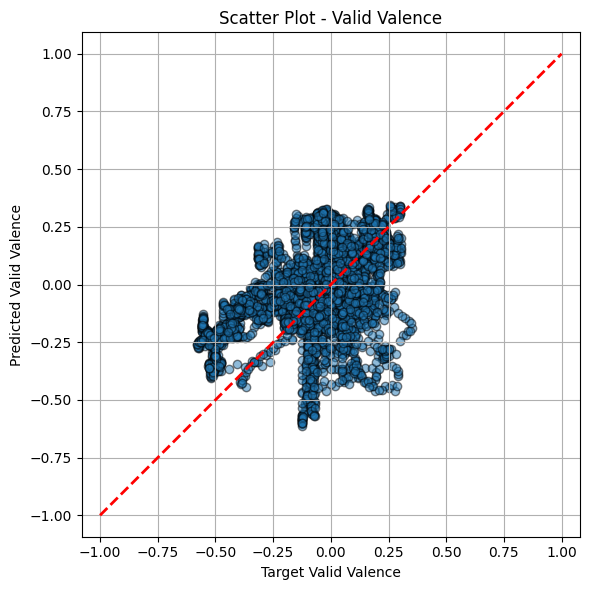

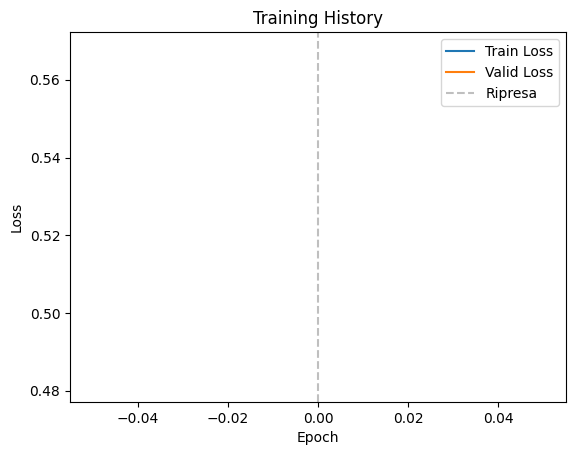


🔁 Epoch 2/10
Train Loss: 0.2117 | Val Loss: 0.6945
Train CCC:  0.7953  | Val CCC:  0.3130
Train MAE:  0.1039  | Val MAE:  0.1570
✅ Checkpoint salvato in /content/drive/MyDrive/checkpoints7/last.ckpt
⏸️ No improvement (1/4)


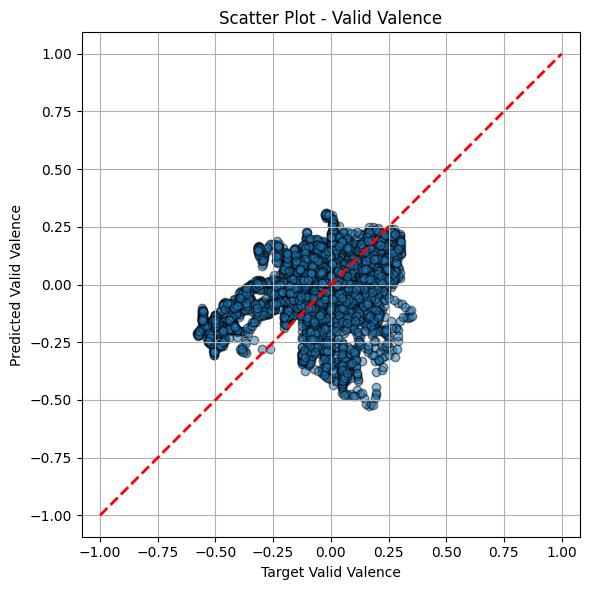

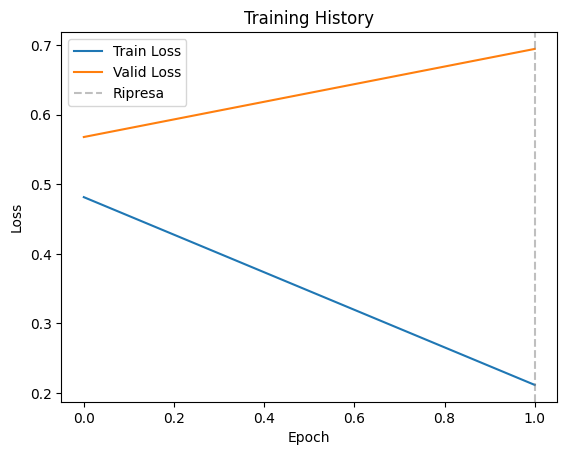


🔁 Epoch 3/10
Train Loss: 0.1362 | Val Loss: 0.5641
Train CCC:  0.8693  | Val CCC:  0.4486
Train MAE:  0.0827  | Val MAE:  0.1676
✅ Checkpoint salvato in /content/drive/MyDrive/checkpoints7/last.ckpt
✅ Checkpoint salvato in /content/drive/MyDrive/checkpoints7/best.ckpt
✅ New best model saved.


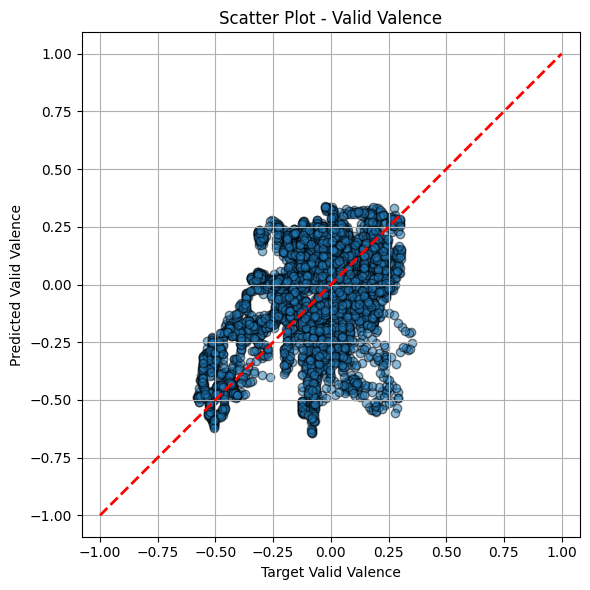

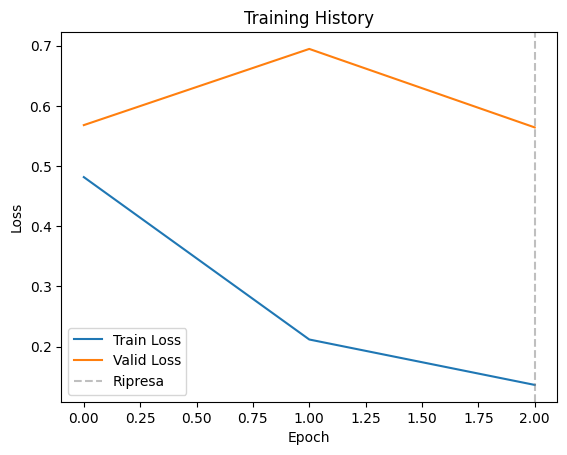


🔁 Epoch 4/10
Train Loss: 0.0981 | Val Loss: 0.6492
Train CCC:  0.9056  | Val CCC:  0.3623
Train MAE:  0.0702  | Val MAE:  0.1748
✅ Checkpoint salvato in /content/drive/MyDrive/checkpoints7/last.ckpt
⏸️ No improvement (1/4)


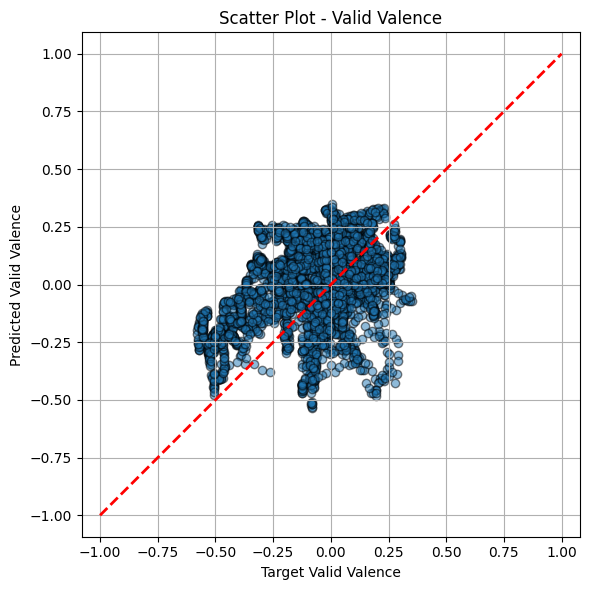

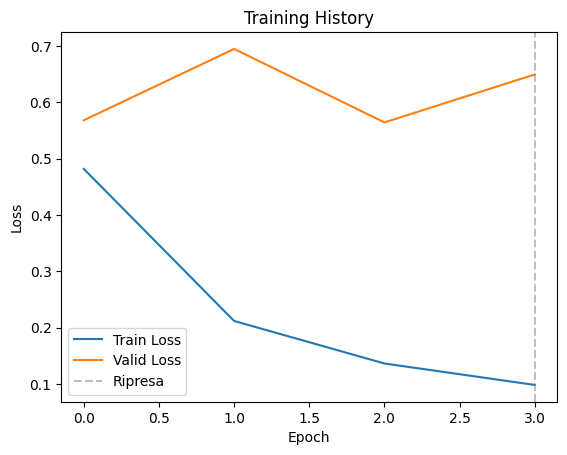


🔁 Epoch 5/10
Train Loss: 0.0739 | Val Loss: 0.6898
Train CCC:  0.9286  | Val CCC:  0.3182
Train MAE:  0.0613  | Val MAE:  0.1812
✅ Checkpoint salvato in /content/drive/MyDrive/checkpoints7/last.ckpt
⏸️ No improvement (2/4)


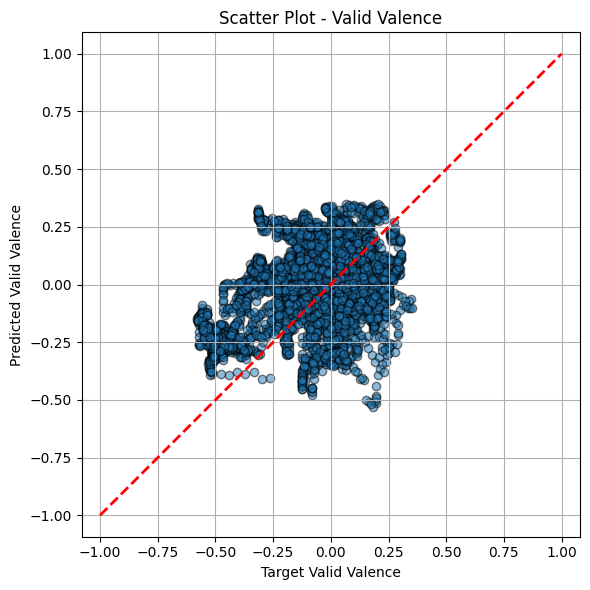

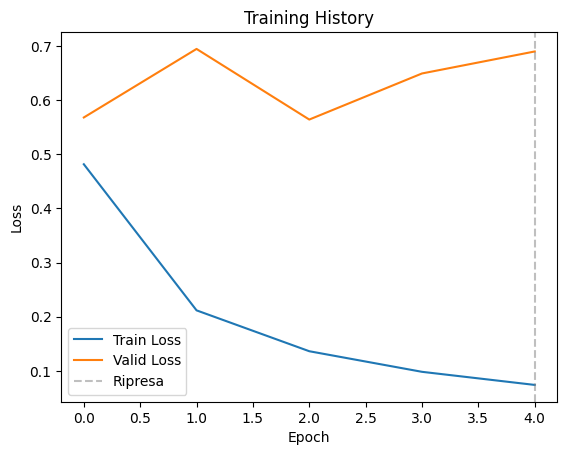


🔁 Epoch 6/10
Train Loss: 0.0643 | Val Loss: 0.6911
Train CCC:  0.9382  | Val CCC:  0.3186
Train MAE:  0.0568  | Val MAE:  0.1686
✅ Checkpoint salvato in /content/drive/MyDrive/checkpoints7/last.ckpt
⏸️ No improvement (3/4)


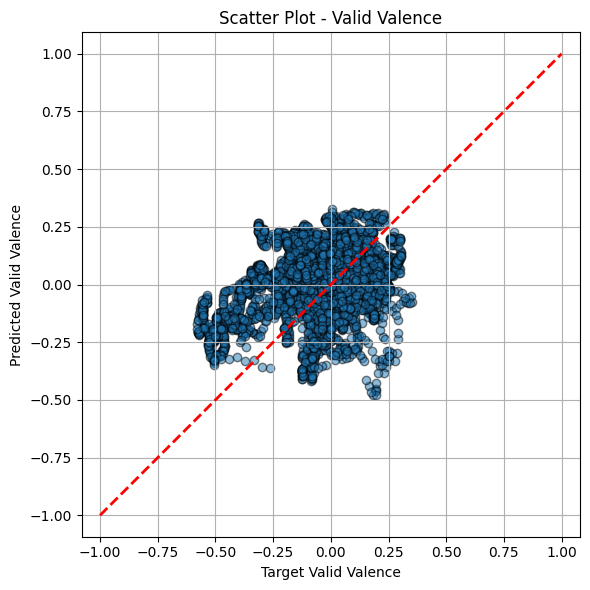

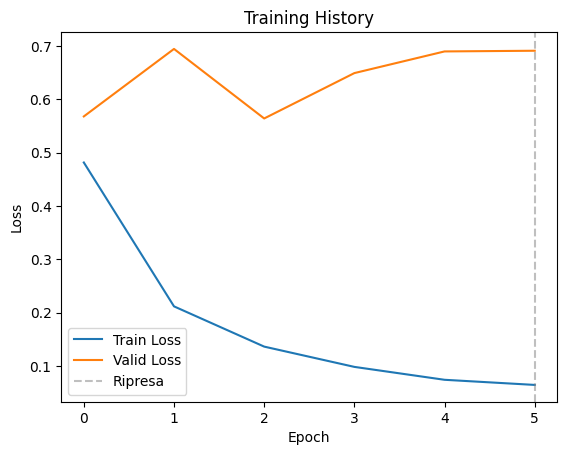


🔁 Epoch 7/10
Train Loss: 0.0551 | Val Loss: 0.6595
Train CCC:  0.9468  | Val CCC:  0.3483
Train MAE:  0.0524  | Val MAE:  0.1711
✅ Checkpoint salvato in /content/drive/MyDrive/checkpoints7/last.ckpt
⏸️ No improvement (4/4)
⛔ Early stopping.


In [ ]:
# Inizializzazione e training
model = CNNRNNAttention()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = train_model(
    model,
    train_loader=train_loader,
    val_loader=devel_loader,
    num_epochs=10,
    patience=4,
    lr=5e-4,
    checkpoint_dir='/content/drive/MyDrive/checkpoints6',
    resume=False,
    start_from_epoch=None,
    device=device
)

✅ Modello caricato da /content/drive/MyDrive/checkpoints7/best.ckpt (epoca 2)


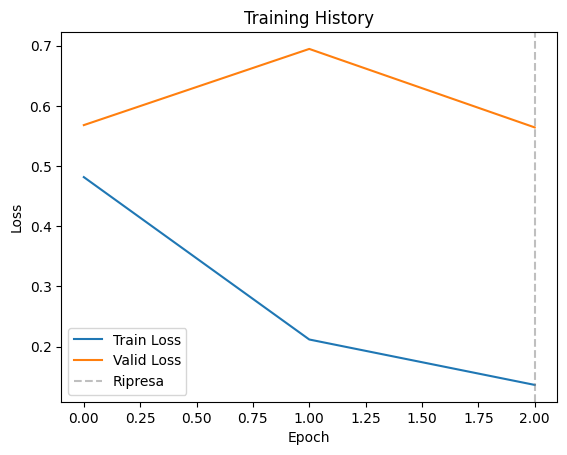

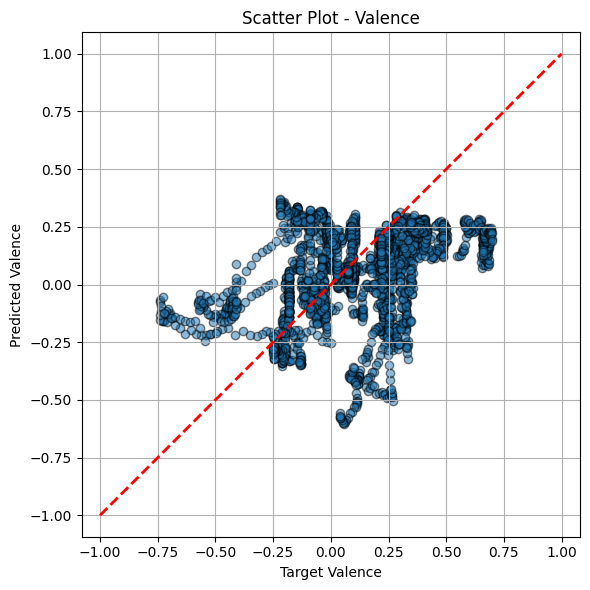


📊 Test MSE: 0.0802 | MAE: 0.2246 | CCC: 0.3359


In [ ]:
model = CNNRNNAttention()
model, history, last_epoch = load_model_for_eval(
    model,
    '/content/drive/MyDrive/checkpoints6/best.ckpt',
    device='cuda',
    load_history=True
)

if history:
    plot_history(history, start_epoch=last_epoch+1)

mse, mae, ccc_v = evaluate(
    model,
    test_loader,
    device='cuda'
)

In [ ]:
pip install torchinfo

In [ ]:
from torchinfo import summary

model = DualHeadCNNRNNAttention()
summary(model, input_size=(1, 8, 1, 128, 34))

Layer (type:depth-idx)                   Output Shape              Param #
DualHeadCNNRNNAttention                  [1, 1]                    --
├─Sequential: 1-1                        [8, 32, 8, 2]             --
│    └─Conv2d: 2-1                       [8, 8, 128, 34]           80
│    └─BatchNorm2d: 2-2                  [8, 8, 128, 34]           16
│    └─ELU: 2-3                          [8, 8, 128, 34]           --
│    └─MaxPool2d: 2-4                    [8, 8, 64, 17]            --
│    └─Conv2d: 2-5                       [8, 16, 64, 17]           1,168
│    └─BatchNorm2d: 2-6                  [8, 16, 64, 17]           32
│    └─ELU: 2-7                          [8, 16, 64, 17]           --
│    └─MaxPool2d: 2-8                    [8, 16, 32, 8]            --
│    └─Conv2d: 2-9                       [8, 32, 32, 8]            4,640
│    └─BatchNorm2d: 2-10                 [8, 32, 32, 8]            64
│    └─ELU: 2-11                         [8, 32, 32, 8]            --
│    └─Ma